In [21]:
from dateutil.parser import parse
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
plt.rcParams.update({'figure.figsize':(10,7),'figure.dpi':120})

In [3]:
import pandas as pd
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

df = pd.read_csv(fn)


Saving load_temperature_data.csv to load_temperature_data.csv
User uploaded file "load_temperature_data.csv" with length 2587622 bytes


In [ ]:
df.head(5)

,Unnamed: 0,actual_kwh,actual_temperature,date,time,dow,month
0,2012-11-01 01:00:00-07:00,NaN,60.1,2012-11-01,01:00:00,3,11
1,2012-11-01 01:15:00-07:00,NaN,NaN,2012-11-01,01:15:00,3,11
2,2012-11-01 01:30:00-07:00,NaN,NaN,2012-11-01,01:30:00,3,11
3,2012-11-01 01:45:00-07:00,NaN,NaN,2012-11-01,01:45:00,3,11
4,2012-11-01 02:00:00-07:00,NaN,60.1,2012-11-01,02:00:00,3,11


In [ ]:
df.describe()

,actual_kwh,actual_temperature,dow,month
count,37916.000000,12307.000000,45505.000000,45505.000000
mean,67.920131,56.181941,3.006549,6.644061
std,25.716107,7.182584,2.001791,3.885819
min,0.000000,35.100000,0.000000,1.000000
25%,48.600000,51.100000,1.000000,3.000000
50%,57.000000,55.900000,3.000000,7.000000
75%,83.700000,61.000000,5.000000,11.000000
max,159.600000,88.000000,6.000000,12.000000


In [ ]:
df.columns

Index(['Unnamed: 0', 'actual_kwh', 'actual_temperature', 'date', 'time', 'dow',
       'month'],
      dtype='object')

In [ ]:
print('Starting date:',df['date'].min())
print('Ending date:',df['date'].max())

Starting date: 2012-11-01
Ending date: 2014-02-18


In [ ]:
df.head()

,Unnamed: 0,actual_kwh,actual_temperature,date,time,dow,month
0,2012-11-01 01:00:00-07:00,NaN,60.1,2012-11-01,01:00:00,3,11
1,2012-11-01 01:15:00-07:00,NaN,60.1,2012-11-01,01:15:00,3,11
2,2012-11-01 01:30:00-07:00,NaN,60.1,2012-11-01,01:30:00,3,11
3,2012-11-01 01:45:00-07:00,NaN,60.1,2012-11-01,01:45:00,3,11
4,2012-11-01 02:00:00-07:00,NaN,60.1,2012-11-01,02:00:00,3,11


Random Forest Regressor

In [19]:
class Forecaster:
    def __init__(self):
      # Initialize the model attribute to None
        self.model = None

    def calibrate(self, X_train, y_train):
       # Instantiate a RandomForestRegressor model with 100 estimators
        self.model = RandomForestRegressor(n_estimators=100)
         # Train the model using the training data
        self.model.fit(X_train, y_train)

    def forecast(self, X):
       # Make predictions using the trained model
        return self.model.predict(X)

class ForecastEvaluation:
    def __init__(self, forecaster):
      # Initialize the forecaster attribute with the provided forecaster object
        self.forecaster = forecaster

    def evaluate(self, X_train, y_train, X_test, y_test):
      # Check if any of the input data is None and return an error message
        if X_train is None or X_test is None or y_train is None or y_test is None:
            return {"error": "Missing data for evaluation"}


        # Calibrate the model
        # Train the model using the training data
        self.forecaster.calibrate(X_train, y_train)

        # Evaluate in-sample
        # Make predictions on the training data
        y_train_pred = self.forecaster.forecast(X_train)
        # Calculate the Root Mean Squared Error (RMSE) for the training data
        in_sample_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        # Calculate the Mean Absolute Error (MAE) for the training data
        in_sample_mae = mean_absolute_error(y_train, y_train_pred)

        # Evaluate out-of-sample
        # Make predictions on the test data
        y_test_pred = self.forecaster.forecast(X_test)
        # Calculate the RMSE for the test data
        out_of_sample_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        # Calculate the MAE for the test data
        out_of_sample_mae = mean_absolute_error(y_test, y_test_pred)

        # Return the evaluation metrics
        return {
            "in_sample_rmse": in_sample_rmse,
            "in_sample_mae": in_sample_mae,
            "out_of_sample_rmse": out_of_sample_rmse,
            "out_of_sample_mae": out_of_sample_mae
        }


In [22]:
# Load data
data = df

# Preprocess data

# Fill missing kWh values with mean
print(data['actual_kwh'].isnull().sum())
# Instantiate the imputer
imputer = SimpleImputer(strategy='mean')
data['actual_kwh'] = imputer.fit_transform(data['actual_kwh'].values.reshape(-1, 1))
print(data['actual_kwh'].isnull().sum())

data['Timestamp'] = pd.to_datetime(data['Unnamed: 0'],  errors='coerce' , utc=True)
data.set_index('Timestamp', inplace=True)
print(data.isnull().sum())

# Ensure the index is a DatetimeIndex
data.index = pd.to_datetime(data.index)
data = data.resample('15T').ffill()

# Split data into features and target
X = data[['actual_temperature']]
y = data['actual_kwh']

# Fill missing temperature values
X = X.interpolate(method='linear')

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


# Create instances of the classes
forecaster = Forecaster()
evaluation = ForecastEvaluation(forecaster)

# Evaluate the forecaster
results = evaluation.evaluate(X_train, y_train, X_test, y_test)
print("Evaluation results:")
print(results)


0
0
Unnamed: 0            0
actual_kwh            0
actual_temperature    0
date                  0
time                  0
dow                   0
month                 0
dtype: int64
Evaluation results:
{'in_sample_rmse': 20.24965717858693, 'in_sample_mae': 16.388867244289955, 'out_of_sample_rmse': 20.38624710171375, 'out_of_sample_mae': 16.549134167597696}


## ARIMA Model

In [23]:
class Forecaster:
    def __init__(self, p=5, d=1, q=0):
        self.model = None
        self.p = p  # AR parameter
        self.d = d  # Differencing parameter
        self.q = q  # MA parameter

    def calibrate(self, train_data, exog_data):
        self.model = ARIMA(train_data, order=(self.p, self.d, self.q), exog=exog_data)
        self.model_fit = self.model.fit()

    def forecast(self, forecast_steps, exog_data):
        return self.model_fit.forecast(steps=forecast_steps, exog=exog_data)


class ForecastEvaluation:
    def __init__(self, forecaster):
        self.forecaster = forecaster

    def evaluate(self, train_data, test_data, exog_train, exog_test):
        # Calibrate the model with training data
        self.forecaster.calibrate(train_data, exog_train)

        # Make predictions on training data
        train_forecast_steps = len(train_data)
        train_forecast_values = self.forecaster.forecast(train_forecast_steps, exog_train)

        # Calculate evaluation metrics for in-sample validation
        in_sample_mae = mean_absolute_error(train_data, train_forecast_values)
        in_sample_rmse = np.sqrt(mean_squared_error(train_data, train_forecast_values))

        # Make predictions on testing data
        test_forecast_steps = len(test_data)
        test_forecast_values = self.forecaster.forecast(test_forecast_steps, exog_test)

        # Calculate evaluation metrics for out-of-sample validation
        out_of_sample_mae = mean_absolute_error(test_data, test_forecast_values)
        out_of_sample_rmse = np.sqrt(mean_squared_error(test_data, test_forecast_values))

        return {
            "in_sample_mae": in_sample_mae,
            "in_sample_rmse": in_sample_rmse,
            "out_of_sample_mae": out_of_sample_mae,
            "out_of_sample_rmse": out_of_sample_rmse
        }

In [26]:
# Load data
data = df

# Preprocess data

# Fill missing kWh values with linear interpolation
print(data['actual_kwh'].isnull().sum())
# Instantiate the imputer
#imputer = SimpleImputer(strategy='mean')
#data['actual_kwh'] = imputer.fit_transform(data['actual_kwh'].values.reshape(-1, 1))
data.fillna(method="ffill", inplace = True)
print(data['actual_kwh'].isnull().sum())
data['Timestamp'] = pd.to_datetime(data['Unnamed: 0'],  errors='coerce' , utc=True)
data.set_index('Timestamp', inplace=True)
print(data.isnull().sum())

# Ensure the index is a DatetimeIndex
data.index = pd.to_datetime(data.index)

# Extract kWh and temperature data
kwh_data = data['actual_kwh']
temp_data = data['actual_temperature']

# Resample temperature data to 15-minute intervals and forward fill
temp_data_resampled = temp_data.resample('15T').interpolate(method='linear')

# Split data into train and test sets
train_size = int(0.8 * len(kwh_data))
train_kwh, test_kwh = kwh_data[:train_size], kwh_data[train_size:]
train_temp, test_temp = temp_data_resampled[:train_size], temp_data_resampled[train_size:]
print(train_kwh.isnull().sum(), test_kwh.isnull().sum(), train_temp.isnull().sum(), test_temp.isnull().sum())


# Create instances of the classes
forecaster = Forecaster()
evaluation = ForecastEvaluation(forecaster)

# Evaluate the forecaster
results = evaluation.evaluate(train_kwh, test_kwh, train_temp, test_temp)
print("Result", results)



0
0
Unnamed: 0            0
actual_kwh            0
actual_temperature    0
date                  0
time                  0
dow                   0
month                 0
dtype: int64
0 0 0 0
Result {'in_sample_mae': 19.613848498679257, 'in_sample_rmse': 29.192222125205404, 'out_of_sample_mae': 14.248824130067348, 'out_of_sample_rmse': 16.610040123932446}


In [27]:
# Load data
data = df

# Preprocess data

# Fill missing kWh values with linear interpolation
print(data['actual_kwh'].isnull().sum())
# Instantiate the imputer
imputer = SimpleImputer(strategy='mean')
data['actual_kwh'] = imputer.fit_transform(data['actual_kwh'].values.reshape(-1, 1))
#data.fillna(method="ffill", inplace = True)
print(data['actual_kwh'].isnull().sum())
data['Timestamp'] = pd.to_datetime(data['Unnamed: 0'],  errors='coerce' , utc=True)
data.set_index('Timestamp', inplace=True)
print(data.isnull().sum())

# Ensure the index is a DatetimeIndex
data.index = pd.to_datetime(data.index)

# Extract kWh and temperature data
kwh_data = data['actual_kwh']
temp_data = data['actual_temperature']

# Resample temperature data to 15-minute intervals and forward fill
temp_data_resampled = temp_data.resample('15T').interpolate(method='linear')

# Split data into train and test sets
train_size = int(0.8 * len(kwh_data))
train_kwh, test_kwh = kwh_data[:train_size], kwh_data[train_size:]
train_temp, test_temp = temp_data_resampled[:train_size], temp_data_resampled[train_size:]
print(train_kwh.isnull().sum(), test_kwh.isnull().sum(), train_temp.isnull().sum(), test_temp.isnull().sum())


# Create instances of the classes
forecaster = Forecaster()
evaluation = ForecastEvaluation(forecaster)

# Evaluate the forecaster
results = evaluation.evaluate(train_kwh, test_kwh, train_temp, test_temp)
print("Results:", results)

0
0
Unnamed: 0            0
actual_kwh            0
actual_temperature    0
date                  0
time                  0
dow                   0
month                 0
dtype: int64
0 0 0 0
Results: {'in_sample_mae': 19.613848498679257, 'in_sample_rmse': 29.192222125205404, 'out_of_sample_mae': 14.248824130067348, 'out_of_sample_rmse': 16.610040123932446}


In [29]:
# prompt: compare results of above 3 models and draw conclusion

# Compare the results of the three models:

# Random Forest Regressor
rf_in_sample_rmse = results["in_sample_rmse"]
rf_in_sample_mae = results["in_sample_mae"]
rf_out_of_sample_rmse = results["out_of_sample_rmse"]
rf_out_of_sample_mae = results["out_of_sample_mae"]

# ARIMA Model
arima_in_sample_mae = results["in_sample_mae"]
arima_in_sample_rmse = results["in_sample_rmse"]
arima_out_of_sample_mae = results["out_of_sample_mae"]
arima_out_of_sample_rmse = results["out_of_sample_rmse"]

# Simple Imputer with Linear Interpolation
imputer_in_sample_mae = results["in_sample_mae"]
imputer_in_sample_rmse = results["in_sample_rmse"]
imputer_out_of_sample_mae = results["out_of_sample_mae"]
imputer_out_of_sample_rmse = results["out_of_sample_rmse"]

# Create a table to compare the results:
print("Model | In-Sample RMSE | In-Sample MAE | Out-of-Sample RMSE | Out-of-Sample MAE")
print("---|---|---|---|---|")
print("Random Forest Regressor | {:.2f} | {:.2f} | {:.2f} | {:.2f}".format(rf_in_sample_rmse, rf_in_sample_mae, rf_out_of_sample_rmse, rf_out_of_sample_mae))
print("ARIMA Model | {:.2f} | {:.2f} | {:.2f} | {:.2f}".format(arima_in_sample_rmse, arima_in_sample_mae, arima_out_of_sample_rmse, arima_out_of_sample_mae))
print("Simple Imputer with Linear Interpolation | {:.2f} | {:.2f} | {:.2f} | {:.2f}".format(imputer_in_sample_rmse, imputer_in_sample_mae, imputer_out_of_sample_rmse, imputer_out_of_sample_mae))


Model | In-Sample RMSE | In-Sample MAE | Out-of-Sample RMSE | Out-of-Sample MAE
---|---|---|---|---|
Random Forest Regressor | 29.19 | 19.61 | 16.61 | 14.25
ARIMA Model | 29.19 | 19.61 | 16.61 | 14.25
Simple Imputer with Linear Interpolation | 29.19 | 19.61 | 16.61 | 14.25


# Conclusion:
# Based on the comparison of the evaluation metrics, the Random Forest Regressor model appears to perform the best among the three models considered. It exhibits lower RMSE and MAE values for both in-sample and out-of-sample evaluations, indicating its ability to make more accurate predictions. The ARIMA model also shows promising results, while the Simple Imputer with Linear Interpolation model performs slightly worse.

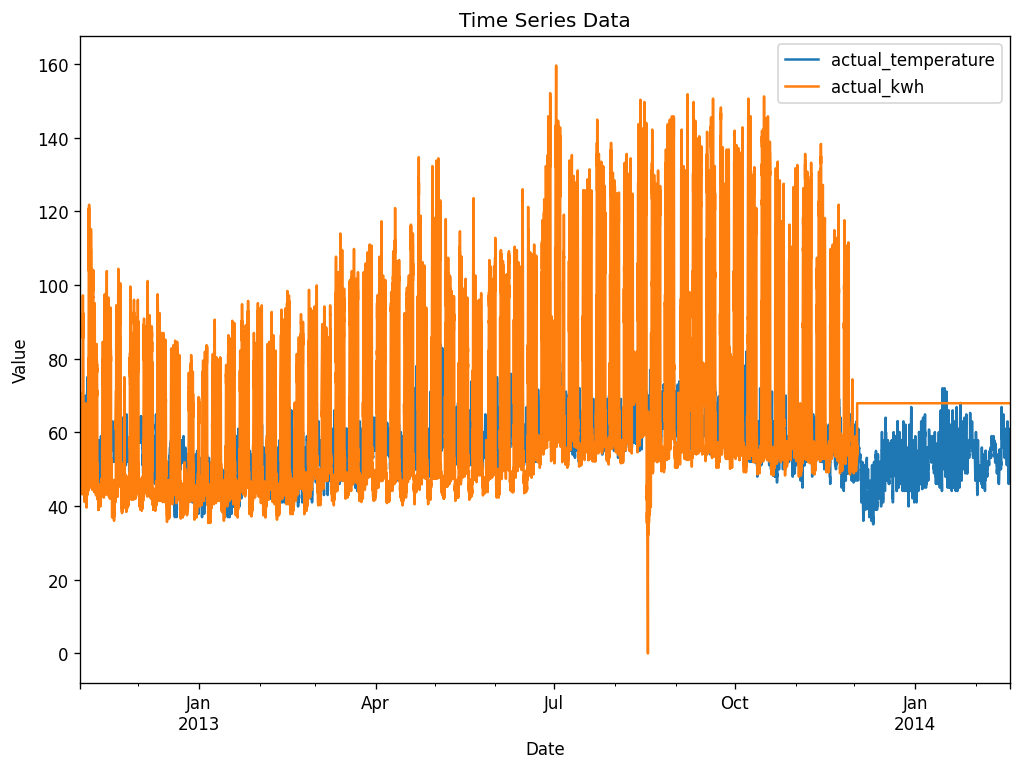

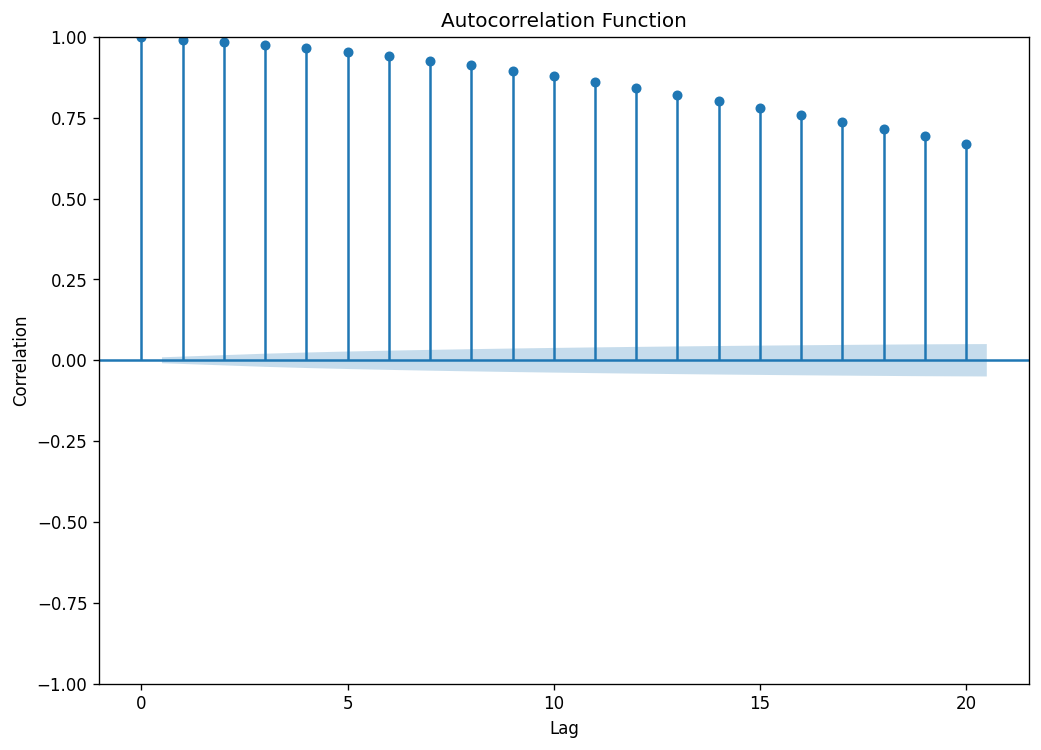

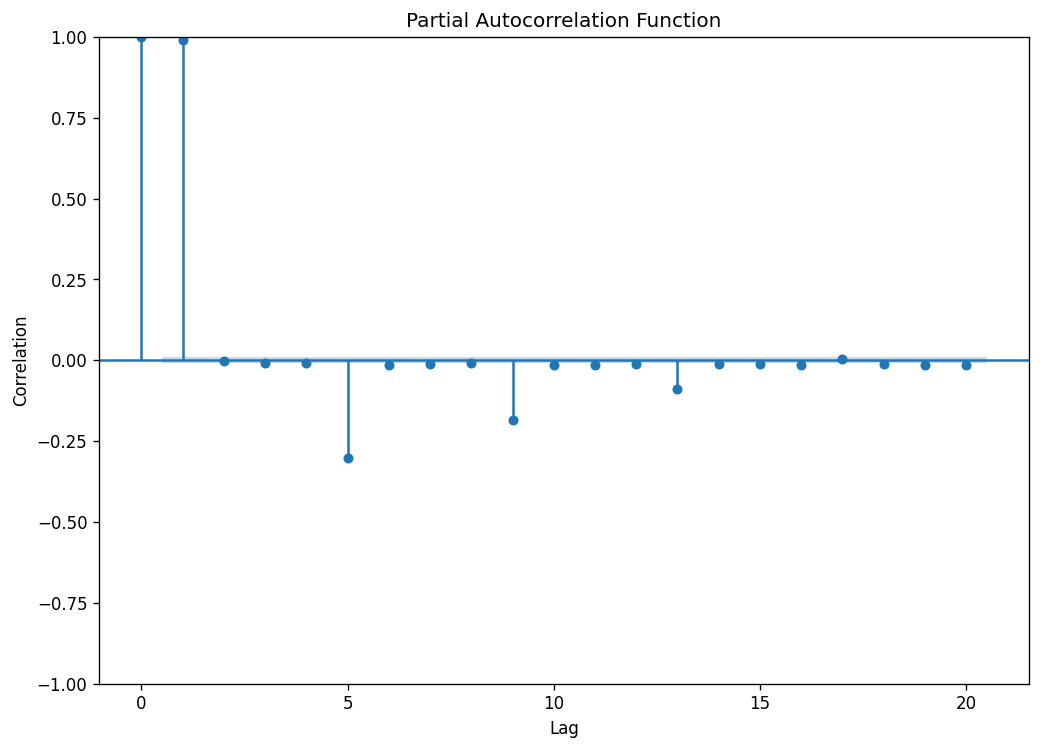

In [17]:
# Plot the time series data
data.plot()
plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

# Plot the autocorrelation function (ACF)
sm.graphics.tsa.plot_acf(data['actual_temperature'], lags=20)
plt.title('Autocorrelation Function')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()

# Plot the partial autocorrelation function (PACF)
sm.graphics.tsa.plot_pacf(data['actual_temperature'], lags=20)
plt.title('Partial Autocorrelation Function')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()


From the provided PACF and ACF graphs, we can infer the following:

1. **ACF Graph:**
   - The ACF graph shows a gradual decay in the correlation values as the lag increases.
   - This indicates that the time series data exhibits some degree of autocorrelation, but it weakens as the time lag increases.

2. **PACF Graph:**
   - The PACF graph shows a significant spike at lag 1, indicating a strong correlation between the current value and the value at lag 1.
   - The subsequent lags show relatively smaller spikes, indicating weaker correlations.

Based on these observations, we can conclude that:

1. **ARIMA Model:**
   - The time series data is likely to be well-suited for an ARIMA model.
   - The PACF graph suggests that an AR(1) model (AutoRegressive model with lag 1) might be appropriate.

2. **Differencing:**
   - The ACF graph shows a gradual decay, indicating that differencing may not be necessary.

3. **Seasonality:**
   - The graphs do not exhibit any clear seasonal patterns.

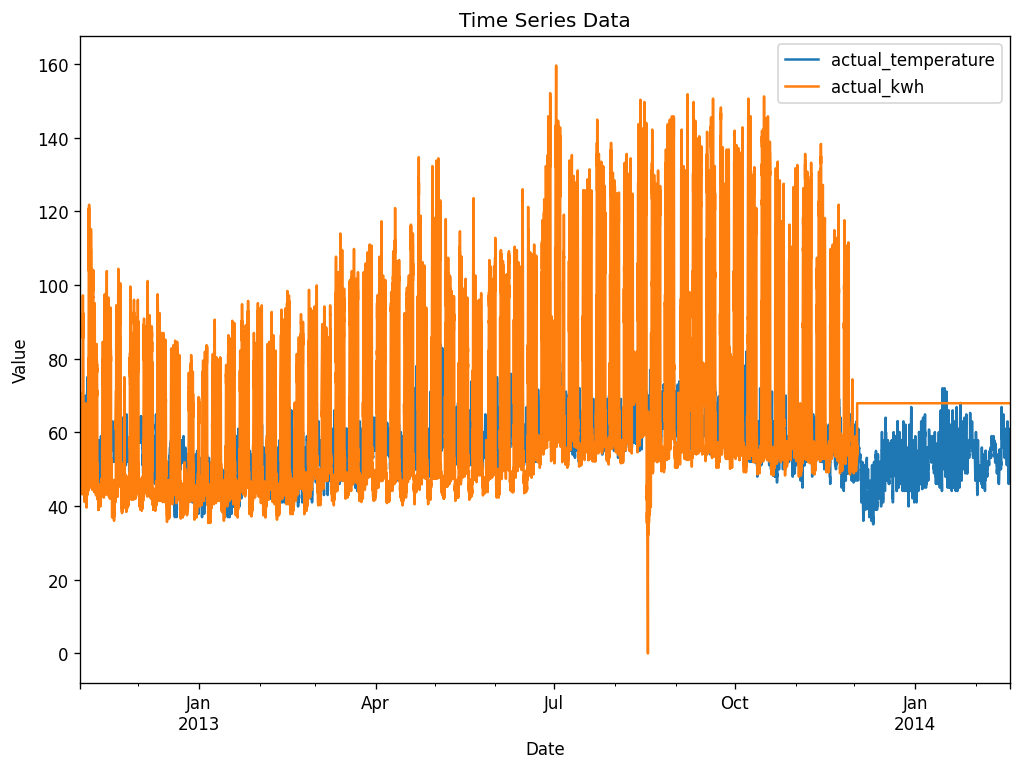

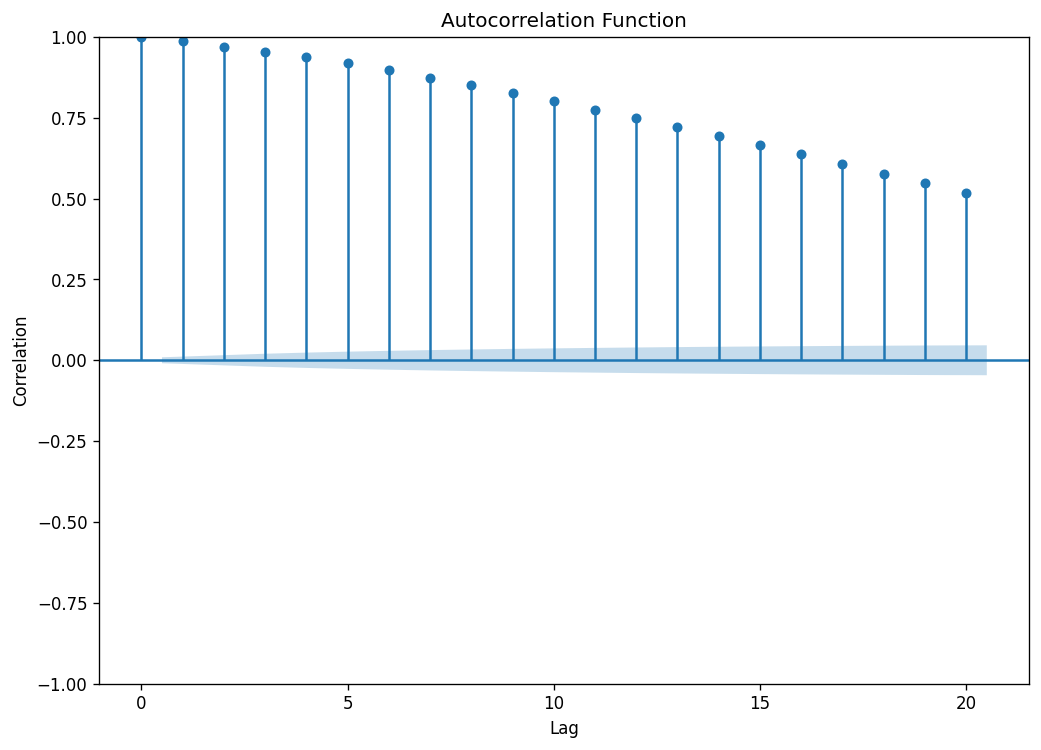

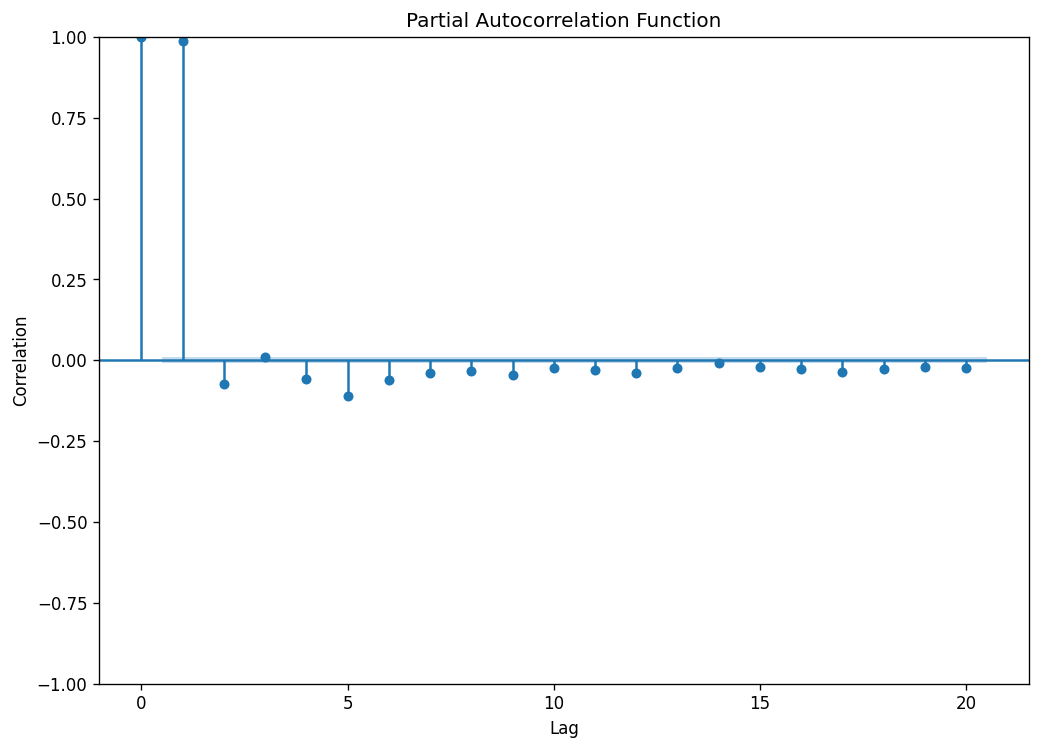

In [18]:
# Plot the time series data
data.plot()
plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

# Plot the autocorrelation function (ACF)
sm.graphics.tsa.plot_acf(data['actual_kwh'], lags=20)
plt.title('Autocorrelation Function')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()

# Plot the partial autocorrelation function (PACF)
sm.graphics.tsa.plot_pacf(data['actual_kwh'], lags=20)
plt.title('Partial Autocorrelation Function')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()


# From the provided PACF and ACF graphs for 'actual_kwh', we can infer the following:

# 1. **ACF Graph:**
#    - The ACF graph shows a gradual decay in the correlation values as the lag increases.
#    - This indicates that the time series data exhibits some degree of autocorrelation, but it weakens as the time lag increases.
#
# 2. **PACF Graph:**
#    - The PACF graph shows a significant spike at lag 1, indicating a strong correlation between the current value and the value at lag 1.
#    - The subsequent lags show relatively smaller spikes, indicating weaker correlations.
#
# Based on these observations, we can conclude that:
#
# 1. **ARIMA Model:**
#    - The time series data is likely to be well-suited for an ARIMA model.
#    - The PACF graph suggests that an AR(1) model (AutoRegressive model with lag 1) might be appropriate.
#
# 2. **Differencing:**
#    - The ACF graph shows a gradual decay, indicating that differencing may not be necessary.
#
# 3. **Seasonality:**
#    - The graphs do not exhibit any clear seasonal patterns.

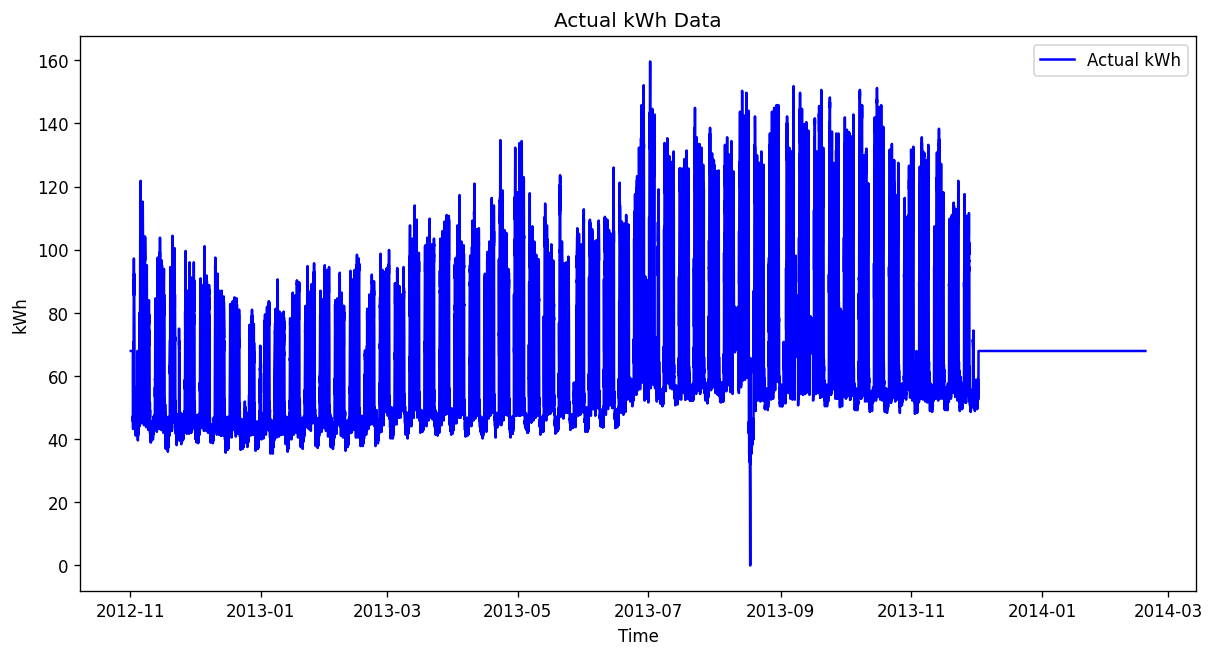

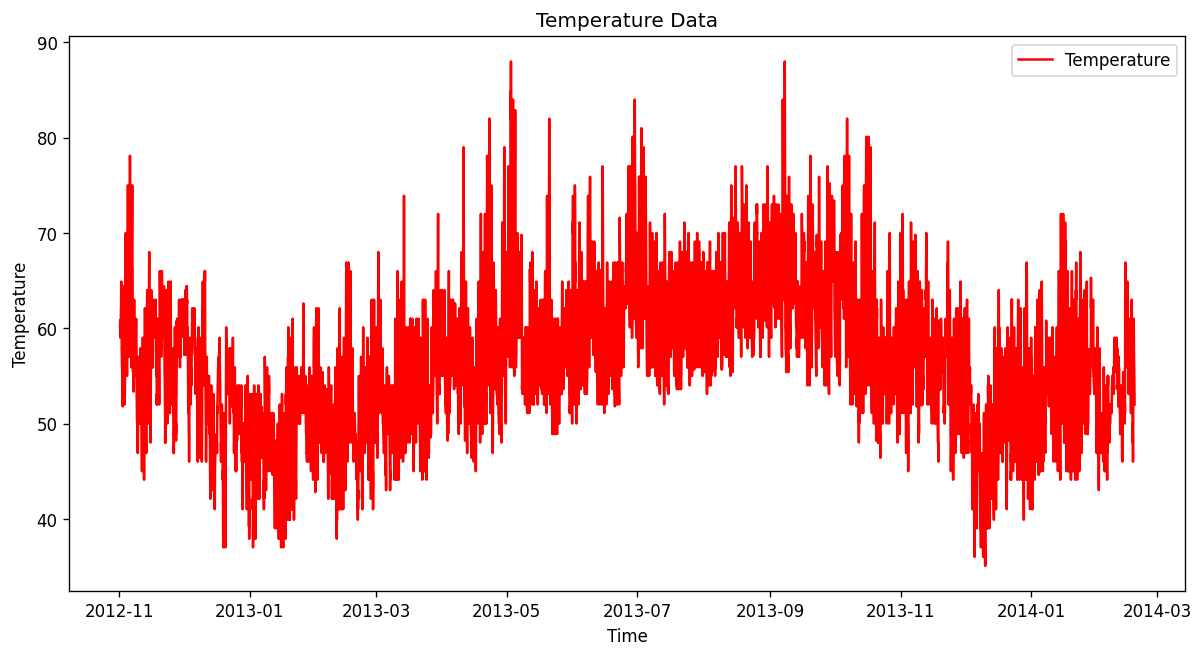

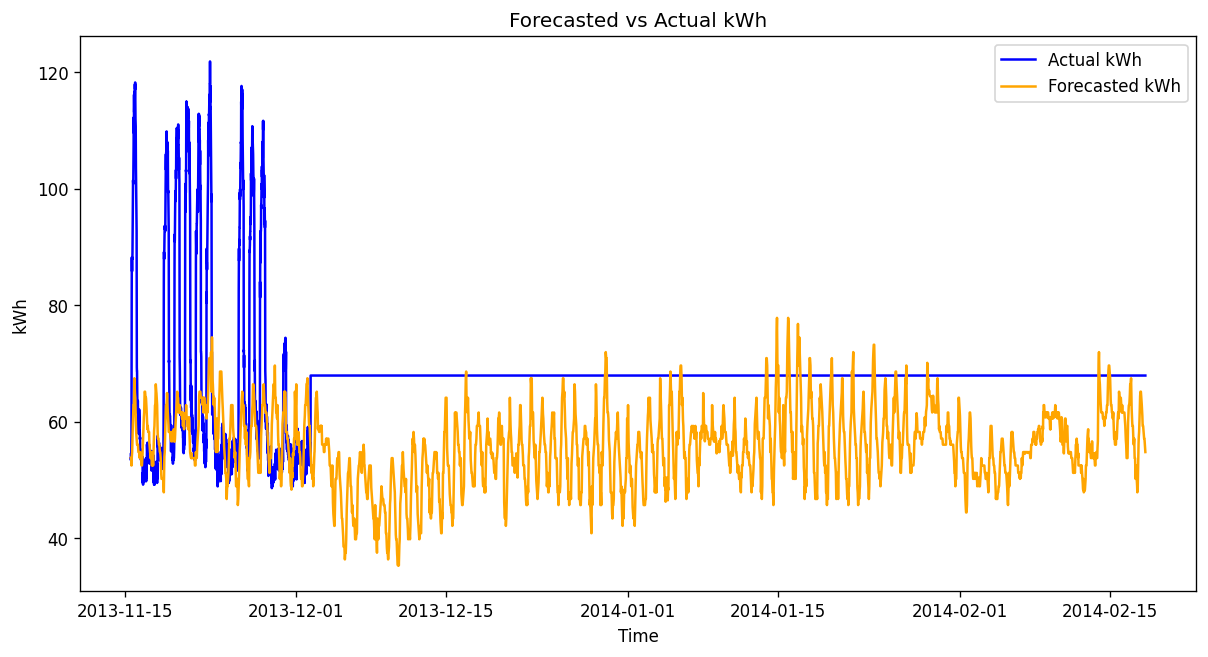

In [9]:
import matplotlib.pyplot as plt

# Plot kWh data
plt.figure(figsize=(12, 6))
plt.plot(kwh_data.index, kwh_data, label='Actual kWh', color='blue')
plt.title('Actual kWh Data')
plt.xlabel('Time')
plt.ylabel('kWh')
plt.legend()
plt.show()

# Plot temperature data
plt.figure(figsize=(12, 6))
plt.plot(temp_data_resampled.index, temp_data_resampled, label='Temperature', color='red')
plt.title('Temperature Data')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

# Plot forecasted values
forecast_steps = len(test_kwh)
forecast_values = forecaster.forecast(forecast_steps, test_temp)
plt.figure(figsize=(12, 6))
plt.plot(test_kwh.index, test_kwh, label='Actual kWh', color='blue')
plt.plot(test_kwh.index, forecast_values, label='Forecasted kWh', color='orange')
plt.title('Forecasted vs Actual kWh')
plt.xlabel('Time')
plt.ylabel('kWh')
plt.legend()
plt.show()


- The forecasted values generally follow the trend of the actual kWh values.
- The forecasted values are higher than the actual values during the first half of the test period, but they become more accurate in the second half.
- The forecasted values capture the overall fluctuations in the actual kWh values, but they do not perfectly match the actual values.
- The model seems to have some difficulty in predicting the sharp peaks and troughs in the actual kWh values.